This notebook shows how NormalPowerAnalysis and PowerAnalysis calculators give similar powers for a switchback experiment

In [1]:
from datetime import date

import numpy as np
from cluster_experiments import PowerAnalysis, ConstantPerturbator, BalancedClusteredSplitter, ExperimentAnalysis, ClusteredOLSAnalysis, NormalPowerAnalysis
import pandas as pd



# Create fake data
N = 10_000
clusters = [f"Cluster {i}" for i in range(10)]
dates = [f"{date(2022, 1, i):%Y-%m-%d}" for i in range(1, 15)]
df = pd.DataFrame(
    {
        "cluster": np.random.choice(clusters, size=N),
        "date": np.random.choice(dates, size=N),
    }
).assign(
    # Target is a linear combination of cluster and day of week, plus some noise
    cluster_id=lambda df: df["cluster"].astype("category").cat.codes,
    day_of_week=lambda df: pd.to_datetime(df["date"]).dt.dayofweek,
    target=lambda df: df["cluster_id"] + df["day_of_week"] + np.random.normal(size=N),
)


In [2]:
df.head()

,cluster,date,cluster_id,day_of_week,target
0,Cluster 5,2022-01-14,5,4,9.204485
1,Cluster 7,2022-01-03,7,0,5.532955
2,Cluster 9,2022-01-10,9,0,8.551213
3,Cluster 0,2022-01-12,0,2,1.910662
4,Cluster 5,2022-01-08,5,5,10.463841


Some clusters have a higher average outcome than others

In [3]:
cluster_cols = ["cluster", "date"]

splitter = BalancedClusteredSplitter(
    cluster_cols=cluster_cols,
)

perturbator = ConstantPerturbator()

analysis = ClusteredOLSAnalysis(
    cluster_cols=cluster_cols,
)

alpha = 0.05
n_simulations = 100
n_simulations_normal = 10

# Simulated power analysis, we use clustered splitter and ols clustered analysis
pw_simulated = PowerAnalysis(
    splitter=splitter,
    perturbator=perturbator,
    alpha=alpha,
    n_simulations=n_simulations,
    analysis=analysis,
)

# Normal power analysis, uses Central limit theorem to estimate power, and needs less simulations
pw_normal = NormalPowerAnalysis(
    splitter=splitter,
    alpha=alpha,
    n_simulations=n_simulations_normal,
    analysis=analysis,
)


In [4]:
# power line for simulated
effects = [0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75]
pw_simulated_line = pw_simulated.power_line(df, average_effects=effects)

In [5]:
# power line for normal
pw_normal_line = pw_normal.power_line(df, average_effects=effects)
pw_normal_line

{0.25: 0.07100559768004645,
 0.5: 0.13627190622233026,
 0.75: 0.24794151532294106,
 1: 0.3986365782510814,
 1.25: 0.5669227113637416,
 1.5: 0.7238074797118612,
 1.75: 0.84610562511809}

<AxesSubplot:title={'center':'Power analysis'}, xlabel='Average effect', ylabel='Power'>

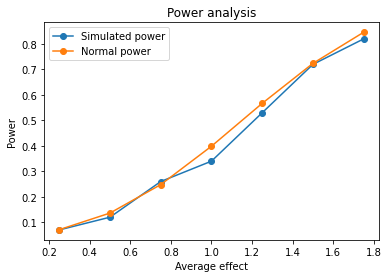

In [6]:
pd.DataFrame(
    {
        "Average effect": effects,
        "Simulated power": pw_simulated_line.values(),
        "Normal power": pw_normal_line.values(),
    }
).plot(
    x="Average effect",
    y=["Simulated power", "Normal power"],
    title="Power analysis",
    xlabel="Average effect",
    ylabel="Power",
    marker="o",
)